<a href="https://colab.research.google.com/github/rlc113/RyanCaginalp_CDC/blob/main/Code_A_Chip_CDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
PITT Circuit Lab, December 2023
SPDX-License-Identifier: Apache-2.0
```

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|In Hee Lee (Advisor)|University of Pittsburgh|Yes|Yes|
|Ryan Caginalp (Lead)|University of Pittsburgh|No|No|

#CDC Generator
This notebook implements a capacitor-to-digital converter (CDC) generator that creates a custom design based off of user input. It can either target an specific feature that the user provides or attempt to maximize an FoM function. In both cases, it will prompt the user with the five best designs and the user will be able to pick whichever design they feel is best. The generator will run the design through an automatic process and output a GDS file. It will also conduct DRC and LVS, and run simulations to confirm functionality.  
To understand how the generator functions, some background is required. Firstly, the CDC is based off of a previous design in [1]. A schematic from [1] is shown below:

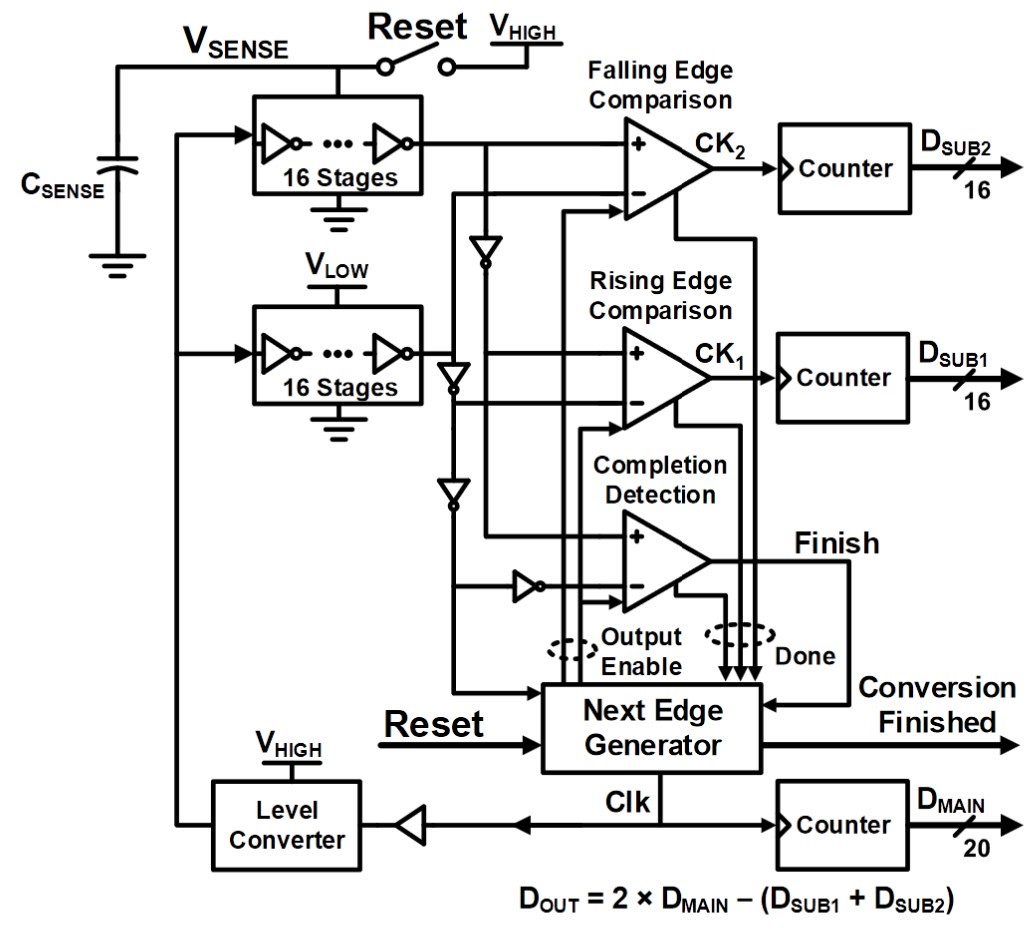

Before discussing operation, there are several properties to note. Firstly, there are two main inverter chains in the design, one powered by V_SENSE, and another powered by V_LOW. Secondly, the design functions by generating pulses at the beginning of each chain. The D_MAIN counter increments with each of these pulses. By contrast, the D_SUB1 and D_SUB2 counters only increment when it takes longer for the pulses to propogate through the V_SENSE chain than the V_LOW chain. Now we can discuss operation. At the beginning, when RESET is high, the capacitor is charged up to V_HIGH, meaning V_SENSE becomes V_HIGH. This means, at first, that the pulses will travel more quickly through the V_SENSE chain and only the D_MAIN counter will increment. However, over time, these pulses will draw current from the V_SENSE chain and eventually discharge it below V_LOW. When this happens, the pulses will travel more slowly through the V_SENSE chain than the V_LOW chain, causing the D_SUB1 and D_SUB2 counters to also start incrementing. The increments in these counters will exactly cancel the additional increments from the D_MAIN counter, meaning the result will just be the amount of pulses it takes for the capacitor to be discharged from V_HIGH to V_LOW. As it turns out, as long as the discharges from each pulse are small enough, this amount of pulses is linear with respect to the input capacitance. It's also worth noting that the conversion will finish when the delay through the V_SENSE chain exceeds the delay through the V_LOW chain by a certain margin. A graph of the voltages from [1] is also shown below:

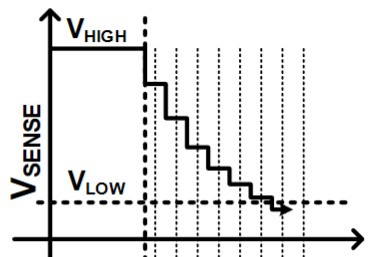

With this background, we can now discuss how the generator works. First, we will consider what would occur if the amount of discharge from each pulse is increased:

1.  Measurement time would decrease - If more charge is lost from the capacitor during each pulse, then it would take less pulses to discharge the capacitor from V_HIGH to V_LOW, resulting in a shorter measurement time.
2.  Resolution would worsen - If more charge is lost from the capacitor during each pulse, then it would take less pulses to discharge the capacitor from V_HIGH to V_LOW. This means we would get a smaller output, meaning that each "tick" in output must correspond to a larger "step", causing the resolution to worsen.
3.  Measurement energy would decrease - Since more charge being lost during each pulse would result in a lower output, there are less pulses generated overall, causing less energy to be consumed.

It is clear now that a change in the discharge capabilities of the V_SENSE chain will, in turn, change several important features of the CDC. Thus, the generator has two methods of altering the discharge capabilities:

1.  Inverter Chain Length - If the inverter chains are longer, each input pulse will cause more inverters to "flip", draining more charge from the capacitor.
2.  Inverter Size - If each inverter in the chain is bigger, then the output and input capacitance of each inverter will increase, meaning more charge is required from the capacitor for each input pulse.

However, these methods are not equal in the way they affect the properties - in particular, The former method won't be as capable as decreasing the measurement time as the latter, since it also would increase the amount of time it would take for each pulse to propagate through when increasing the length of the chain. However, we have far more fine-grain control over the chain length compared to the size. To summarize, we have one control that produces superior qualities, but is coarse-grain, and another that produces inferior qualities, but is fine-grain.

This notebook also uses several components and design methodologies from the temperature sensor generator found in [2].

##References
[1] Wanyeong Jung, Seokhyeon Jeong, Sechang Oh, Sylvester, D., & Blaauw, D. (2015). 27.6 A 0.7pF-to-10nF fully digital capacitance-to-digital converter using iterative delay-chain discharge. 2015 IEEE International Solid State Circuits Conference (ISSCC), 2015, 1–3. https://doi.org/10.1109/ISSCC.2015.7063137  
[2] https://colab.research.google.com/github/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/temp-sense-gen/temp_sense_genCollab.ipynb

# Install Dependencies
First, we must install the open-source tools that the CDC generator uses. These tools include (the versions for which the notebook has been confirmed to function correctly under are in parenthesis):

*   Yosys, for logic synthesis. (Version 0.35)
*   OpenROAD, for routing, placement, and other processes. (Version 0922eecb9b6a9de5fc7209e11f0781c75d2a0ff2)
*   Magic, for DRC, Layout SPICE file extraction, and other processes. (Version 8.3.450)
*   KLayout, for GDS integration. (Version 0.28.12)
*   Netgen, for LVS. (Version 1.5.263)
*   NgSpice, for simulation. (Version 36)
*   SKY130, the open-source PDK that the generator uses. (Version 1.0.458)



In [ ]:
import os
import pathlib
import sys

!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        netgen \
                        openroad \
                        yosys \
                        klayout
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib pyyaml click svgutils ngspice
!python -m pip install gdstk gdstk


PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

!git clone https://github.com/rlc113/RyanCaginalp_CDC


Streaming output truncated to the last 5000 lines.
Extracting   (1)  ⣾  [+] 6m:34.1s
Extracting   (1)  ⣾  [+] 6m:34.2s
Extracting   (1)  ⣾  [+] 6m:34.3s
Extracting   (1)  ⣾  [+] 6m:34.4s
Extracting   (1)  ⣾  [+] 6m:34.5s
Extracting   (1)  ⣾  [+] 6m:34.6s
Extracting   (1)  ⣾  [+] 6m:34.7s
Extracting   (1)  ⣾  [+] 6m:34.8s
Extracting   (1)  ⣾  [+] 6m:34.9s
Extracting   (1)  ⣾  [+] 6m:35.0s
Extracting   (1)  ⣾  [+] 6m:35.1s
Extracting   (1)  ⣾  [+] 6m:35.2s
Extracting   (1)  ⣾  [+] 6m:35.3s
Extracting   (1)  ⣾  [+] 6m:35.4s
Extracting   (1)  ⣾  [+] 6m:35.5s
Extracting   (1)  ⣾  [+] 6m:35.6s
Extracting   (1)  ⣾  [+] 6m:35.7s
Extracting   (1)  ⣾  [+] 6m:35.8s
Extracting   (1)  ⣾  [+] 6m:35.9s
Extracting   (1)  ⣾  [+] 6m:36.0s
Extracting   (1)  ⣾  [+] 6m:36.1s
Extracting   (1)  ⣾  [+] 6m:36.2s
Extracting   (1)  ⣾  [+] 6m:36.3s
Extracting   (1)  ⣾  [+] 6m:36.4s
Extracting   (1)  ⣾  [+] 6m:36.5s
Extracting   (1)  ⣾  [+] 6m:36.6s
Extracting   (1)  ⣾  [+] 6m:36.7s
Extracting   (1)  ⣾  [+] 6m:36.

#Input Settings
#### The following settings control various functionalities of the generator - such as whether it tries to target a specific feature or maximize a user-defined FoM function.

## Interpolation
The following checkbox controls whether the generator considers interpolated designs. If so, the generator will consider designs that weren't simulated, but whose properties were linearly interpolated from existing data. If unchecked, only directly simulated designs will be considered.

In [ ]:
interpolated = True # @param {type:"boolean"}

## Targeted vs FoM
The following dropdown controls whether the generator will attempt to target a specific feature or maximize an FoM function. For the former, the generator will return the five designs that are as close to the targeted value further down. For the latter, the generator will attempt to maximize an FoM that is returned by the FoM function further down.

In [ ]:
Targeted = True
FoM = False
Targeted_or_Fom = FoM # @param ["Targeted", "FoM"] {type:"raw"}

## Target Type and Value
If we choose to target a feature, then we must specify a target type
and value. The type can either be "Energy", "Time", or "Res":

* "Energy" - Conversion Energy per Input Capacitance
* "Time" - Conversion Time per Input Capacitance
* "Res" - Output Step Size. (A rise in the input capacitance by this amount will cause the output to rise by 1)

In [ ]:
target_type = "Res" # @param ["Energy", "Time", "Res"]

We must also choose a target value. This will be set equal to either target_energy, target_time, or target_res, depending on target_type. The units are given below:
* Energy - Joules/Farad
* Time - Seconds/MilliFarad
* Output Step Size - picoFarads

In [ ]:
target_energy =  16 # @param {type:"slider", min:2, max:20, step:0.1}
target_time =  50 # @param {type:"slider", min:2, max:50, step:0.1}
target_res =  3 # @param {type:"slider", min:0, max:3, step:0.01}


if (target_type == "Energy"): target_value = target_energy
if (target_type == "Time"): target_value = target_time
if (target_type == "Res"): target_value = target_res

##FoM Function
The following code segment is the FoM function that the generator will attempt to maximize if configured to do so. E is conversion energy per input capacitance, T is conversion time per input capacitance, and R is output step size. All three have the same units as the target variables. Please bear in mind that all three properties are preferred to be as low as possible when building your own FoM function

In [ ]:
def FoM(E, T, R):
    return (1/(E * T * R))

##Restriction
When the following is checked, all designs outputted by the generator are subject to a restriction, set by the below restriction function. In other words, any design the tool returns must satisfy the restriction.

In [ ]:
restricted = False # @param {type:"boolean"}

###Restriction Function
The following code segment is the restriction function the generator must satisfy when restricted. E, T, and R are the same as they were for the FoM function. When the function returns true, it means the design passes the restriction. If it returns false, the design does not pass.

In [ ]:
def Restriction(E, T, R):
    return (E < 10)

#Verilog Generation
With all of that out of the way, we can now generate our Verilog files. The generator will first look at existing designs, and fetch the five closest to the user specifications. The user can then select a design of the five given, and the generator shall adjust some Verilog templates to create a custom design.

In [ ]:
#Go to the proper directory
%cd /content/RyanCaginalp_CDC

#Import code that will do CDC parameter selection
from MainSelector import *

#Prompt the user to select a design
selected_size, selected_length = MainSelector(interpolated, Targeted_or_Fom, target_type, target_value, FoM, restricted, Restriction)

#Provide the user with some information to verify
print("A design with a chain of " + str(selected_length) + " inverters, each with size " + str(selected_size) + ", has been selected.")
print("Generating Verilog...")

#Generate the Verilog
!python3 Custom_CDC_Generator.py $selected_length 1 $selected_size

#Confirm Generation
print("Verilog Generated!")

/content/RyanCaginalp_CDC
The 5 designs with the highest FoM are shown below:
(1) Inverter Size = 8, Inverter Length = 8: FoM: 0.02972092450859825, Energy per Input Capacitance (J/F): 8.176333333, Time per Input Capacitance (S/mF): 7.818666667, Output Step Size (pF): 0.526315789
(2) Inverter Size = 16, Inverter Length = 20: FoM: 0.02950218723364614, Energy per Input Capacitance (J/F): 5.588166665999999, Time per Input Capacitance (S/mF): 1.8748333339999999, Output Step Size (pF): 3.235294118
(3) Inverter Size = 16, Inverter Length = 8: FoM: 0.02715884603590069, Energy per Input Capacitance (J/F): 7.607, Time per Input Capacitance (S/mF): 4.840333333, Output Step Size (pF): 1.0
(4) Inverter Size = 12, Inverter Length = 8: FoM: 0.026232969946456738, Energy per Input Capacitance (J/F): 7.891666666500001, Time per Input Capacitance (S/mF): 6.3294999999999995, Output Step Size (pF): 0.7631578944999999
(5) Inverter Size = 16, Inverter Length = 18: FoM: 0.025420757922967788, Energy per Input 

#Synthesis
In synthesis, a high-level Verilog circuit description is converted into a list of gates. In our case, the Verilog files are pretty much already just a list of gates, this step just flattens all of the input files into one "sythesized" file. It also generates a SPICE netlist for later use in LVS.

In [ ]:
%cd /content/RyanCaginalp_CDC
!yosys -c Synthesis.tcl

/content/RyanCaginalp_CDC

 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTA

#Floorplanning
In floorplanning, the high-level "design" of the chip is laid out. In our case, this includes pin placement, tapcell and endcap insertion, and power domain planning. For the latter, our design has three types of voltages: V_SENSE, V_HIGH, and V_LOW. V_SENSE is our capacitor voltage, and thus is only connected the inverter chain that discharges the capacitor during operation. V_HIGH is the voltage the capacitor is charged up to before operation, and is thus only connected to the transmission gates that charge it and the the inverter that leads into the inverter chains. V_LOW is the voltage that the rest of the chip uses. As such, V_LOW is supplied by a power ring that spans more-or-less the entire area of the chip, while V_SENSE and V_HIGH occupy the top-left and bottom-left portions, respectively.

In [ ]:
%cd /content/RyanCaginalp_CDC
!openroad Floorplanning1.tcl
!python3 Duplicate_Cap_Remover.py
!openroad Floorplanning2.tcl

/content/RyanCaginalp_CDC
OpenROAD 0922eecb9b6a9de5fc7209e11f0781c75d2a0ff2 
This program is licensed under the BSD-3 license. See the LICENSE file for details.
Components of this program may be licensed under more restrictive licenses which must be honored.
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0223]     Created 13 technology layers
[INFO ODB-0224]     Created 25 technology vias
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0225]     Created 441 library cells
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0222] Reading LEF file: LEF/transmission_gate.lef
[WARNING ODB-0220] WARNING (LEFPARS-2008): NOWIREEXTENSIONATPIN statement is obsolete in version 5.6 or later.
The NOWIREEXTENSIONATPIN statement will be ignored. See file LEF/transmission_gate.lef at line 2.

[INFO ODB-0225]     Created 1 library cells
[INFO ODB-0226] Finished LEF file

The below code segment displays a graphic of the chip after floorplanning is complete. We can see that all three voltage regions have a power ring associated with them, and each region has "rows" where logic gates can be placed.  

/content/RyanCaginalp_CDC
[INFO] Reporting cells prior to loading DEF ...
[INFO] Reading DEF ...
[INFO] Clearing cells...
[INFO] Merging GDS/OAS files...
	GDS/sky130_fd_sc_hd.gds
	GDS/transmission_gate.gds
[INFO] Copying toplevel cell 'CDC'
INFO: Reading config file: JSON/fill.json
[INFO] Checking for missing cell from GDS/OAS...
[INFO] All LEF cells have matching GDS/OAS cells
[INFO] Checking for orphan cell in the final layout...
[INFO] No orphan cells
[INFO] Writing out GDS/OAS 'Floorplanned.gds'


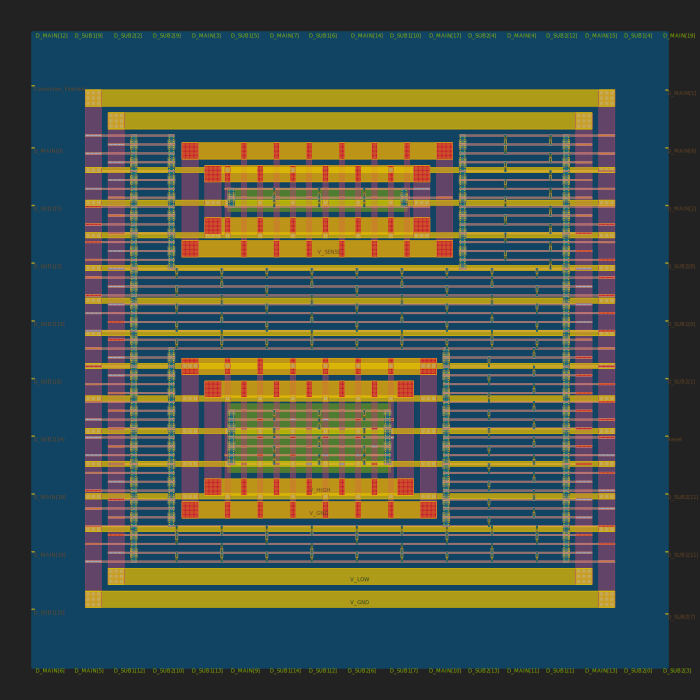

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg

# convert def to gds
%cd /content/RyanCaginalp_CDC
!klayout -zz -rd design_name="CDC" \
         -rd in_def="Floorplanned.def" \
         -rd in_files="GDS/sky130_fd_sc_hd.gds GDS/transmission_gate.gds" \
         -rd config_file="JSON/fill.json" \
         -rd seal_file="" \
         -rd out_file="Floorplanned.gds" \
         -rd tech_file="Klayout_Files/klayout.lyt" \
         -rd layer_map= \
         -r PYTHON/def2stream.py

flrpln = gdstk.read_gds("Floorplanned.gds")
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('Floorplanned.svg')
fig = sg.fromfile('Floorplanned.svg')
fig.set_size(('700','700'))
fig.save('Floorplanned.svg')
IPython.display.SVG('Floorplanned.svg')



#Placement
In placement, the logic gates, known as standard cells, are inserted into the design. Gates that are connected must be placed close together, otherwise it will be impossible to route the connections between them.

In [ ]:
%cd /content/RyanCaginalp_CDC
!openroad Placement.tcl

/content/RyanCaginalp_CDC
OpenROAD 0922eecb9b6a9de5fc7209e11f0781c75d2a0ff2 
This program is licensed under the BSD-3 license. See the LICENSE file for details.
Components of this program may be licensed under more restrictive licenses which must be honored.
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0223]     Created 13 technology layers
[INFO ODB-0224]     Created 25 technology vias
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0225]     Created 441 library cells
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0222] Reading LEF file: LEF/transmission_gate.lef
[WARNING ODB-0220] WARNING (LEFPARS-2008): NOWIREEXTENSIONATPIN statement is obsolete in version 5.6 or later.
The NOWIREEXTENSIONATPIN statement will be ignored. See file LEF/transmission_gate.lef at line 2.

[INFO ODB-0225]     Created 1 library cells
[INFO ODB-0226] Finished LEF file

The below code segment displays a graphic of the chip after placement is complete. We can now see that some portions of the rows are "filled in". These are the gates that were inserted through placement.

/content/RyanCaginalp_CDC
[INFO] Reporting cells prior to loading DEF ...
[INFO] Reading DEF ...
[INFO] Clearing cells...
[INFO] Merging GDS/OAS files...
	GDS/sky130_fd_sc_hd.gds
	GDS/transmission_gate.gds
[INFO] Copying toplevel cell 'CDC'
INFO: Reading config file: JSON/fill.json
[INFO] Checking for missing cell from GDS/OAS...
[INFO] All LEF cells have matching GDS/OAS cells
[INFO] Checking for orphan cell in the final layout...
[INFO] No orphan cells
[INFO] Writing out GDS/OAS 'Placed.gds'


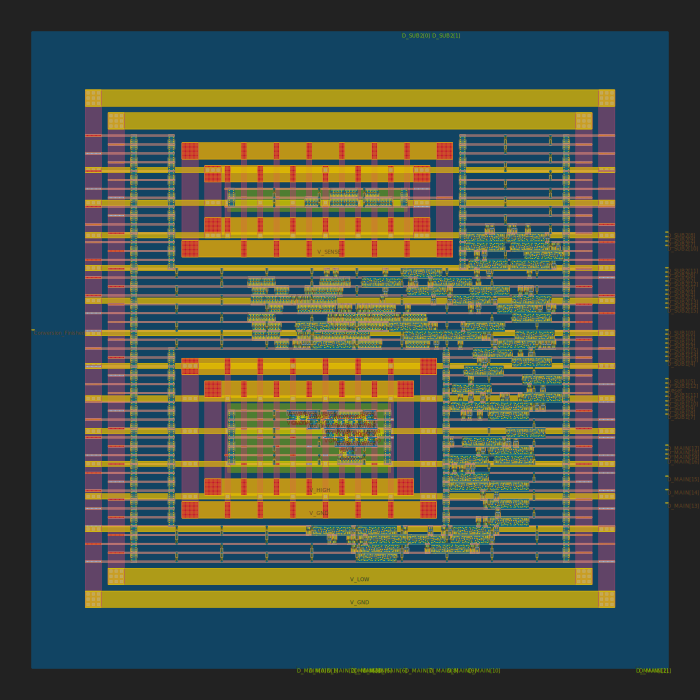

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg

# convert def to gds
%cd /content/RyanCaginalp_CDC
!klayout -zz -rd design_name="CDC" \
         -rd in_def="Placed.def" \
         -rd in_files="GDS/sky130_fd_sc_hd.gds GDS/transmission_gate.gds" \
         -rd config_file="JSON/fill.json" \
         -rd seal_file="" \
         -rd out_file="Placed.gds" \
         -rd tech_file="Klayout_Files/klayout.lyt" \
         -rd layer_map= \
         -r PYTHON/def2stream.py

placed = gdstk.read_gds("Placed.gds")
placed_top_cell = placed.top_level()
placed_top_cell[0].write_svg('Placed.svg')
fig = sg.fromfile('Placed.svg')
fig.set_size(('700','700'))
fig.save('Placed.svg')
IPython.display.SVG('Placed.svg')

#Filler Cell Insertion
You may have noticed that there are gaps in the above graphic between gates. In order for the chip to function correctly, these gaps must be filled. We fill these gaps by inserting what are called filler cells between gates.

In [ ]:
%cd /content/RyanCaginalp_CDC
!openroad FillerInsertion.tcl

/content/RyanCaginalp_CDC
OpenROAD 0922eecb9b6a9de5fc7209e11f0781c75d2a0ff2 
This program is licensed under the BSD-3 license. See the LICENSE file for details.
Components of this program may be licensed under more restrictive licenses which must be honored.
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0223]     Created 13 technology layers
[INFO ODB-0224]     Created 25 technology vias
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0225]     Created 441 library cells
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0222] Reading LEF file: LEF/transmission_gate.lef
[WARNING ODB-0220] WARNING (LEFPARS-2008): NOWIREEXTENSIONATPIN statement is obsolete in version 5.6 or later.
The NOWIREEXTENSIONATPIN statement will be ignored. See file LEF/transmission_gate.lef at line 2.

[INFO ODB-0225]     Created 1 library cells
[INFO ODB-0226] Finished LEF file

The below code segment displays a graphic of the chip after fill cell insertion is complete. We can now see that all of the rows are "filled in" due to the fill cells.

/content/RyanCaginalp_CDC
[INFO] Reporting cells prior to loading DEF ...
[INFO] Reading DEF ...
[INFO] Clearing cells...
[INFO] Merging GDS/OAS files...
	GDS/sky130_fd_sc_hd.gds
	GDS/transmission_gate.gds
[INFO] Copying toplevel cell 'CDC'
INFO: Reading config file: JSON/fill.json
[INFO] Checking for missing cell from GDS/OAS...
[INFO] All LEF cells have matching GDS/OAS cells
[INFO] Checking for orphan cell in the final layout...
[INFO] No orphan cells
[INFO] Writing out GDS/OAS 'Filled.gds'


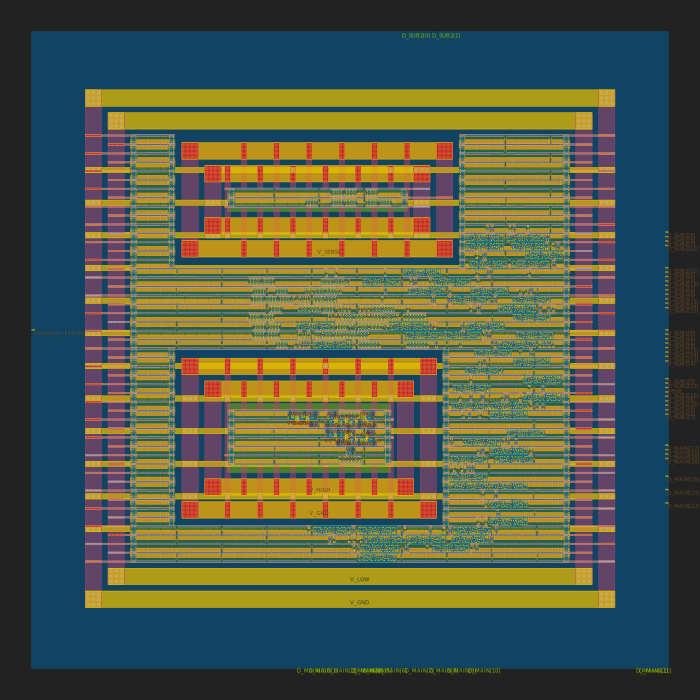

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg

# convert def to gds
%cd /content/RyanCaginalp_CDC
!klayout -zz -rd design_name="CDC" \
         -rd in_def="Filled.def" \
         -rd in_files="GDS/sky130_fd_sc_hd.gds GDS/transmission_gate.gds" \
         -rd config_file="JSON/fill.json" \
         -rd seal_file="" \
         -rd out_file="Filled.gds" \
         -rd tech_file="Klayout_Files/klayout.lyt" \
         -rd layer_map= \
         -r PYTHON/def2stream.py

filled = gdstk.read_gds("Filled.gds")
filled_top_cell = filled.top_level()
filled_top_cell[0].write_svg('Filled.svg')
fig = sg.fromfile('Filled.svg')
fig.set_size(('700','700'))
fig.save('Filled.svg')
IPython.display.SVG('Filled.svg')

#Routing
In routing, the connections between logic gates are formed. This process takes a bit longer than the others, but it should still be well under a minute.

In [ ]:
%cd /content/RyanCaginalp_CDC
!openroad Routing.tcl

/content/RyanCaginalp_CDC
OpenROAD 0922eecb9b6a9de5fc7209e11f0781c75d2a0ff2 
This program is licensed under the BSD-3 license. See the LICENSE file for details.
Components of this program may be licensed under more restrictive licenses which must be honored.
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0223]     Created 13 technology layers
[INFO ODB-0224]     Created 25 technology vias
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd.tlef
[INFO ODB-0222] Reading LEF file: LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0225]     Created 441 library cells
[INFO ODB-0226] Finished LEF file:  LEF/sky130_fd_sc_hd_merged.lef
[INFO ODB-0222] Reading LEF file: LEF/transmission_gate.lef
[WARNING ODB-0220] WARNING (LEFPARS-2008): NOWIREEXTENSIONATPIN statement is obsolete in version 5.6 or later.
The NOWIREEXTENSIONATPIN statement will be ignored. See file LEF/transmission_gate.lef at line 2.

[INFO ODB-0225]     Created 1 library cells
[INFO ODB-0226] Finished LEF file

The below code segment displays a graphic of the chip after routing is complete. We can now see that there are various wires stretching across the chip, connecting various gates together. In paricular, we can now see that the pins are now connected to the chip instead of floating, like they were before. It is also worth noting that the chip design is now complete. The rest of the steps concern with various processes to ensure functionality.

/content/RyanCaginalp_CDC
[INFO] Reporting cells prior to loading DEF ...
[INFO] Reading DEF ...
[INFO] Clearing cells...
[INFO] Merging GDS/OAS files...
	GDS/sky130_fd_sc_hd.gds
	GDS/transmission_gate.gds
[INFO] Copying toplevel cell 'CDC'
INFO: Reading config file: JSON/fill.json
[INFO] Checking for missing cell from GDS/OAS...
[INFO] All LEF cells have matching GDS/OAS cells
[INFO] Checking for orphan cell in the final layout...
[INFO] No orphan cells
[INFO] Writing out GDS/OAS 'Routed.gds'


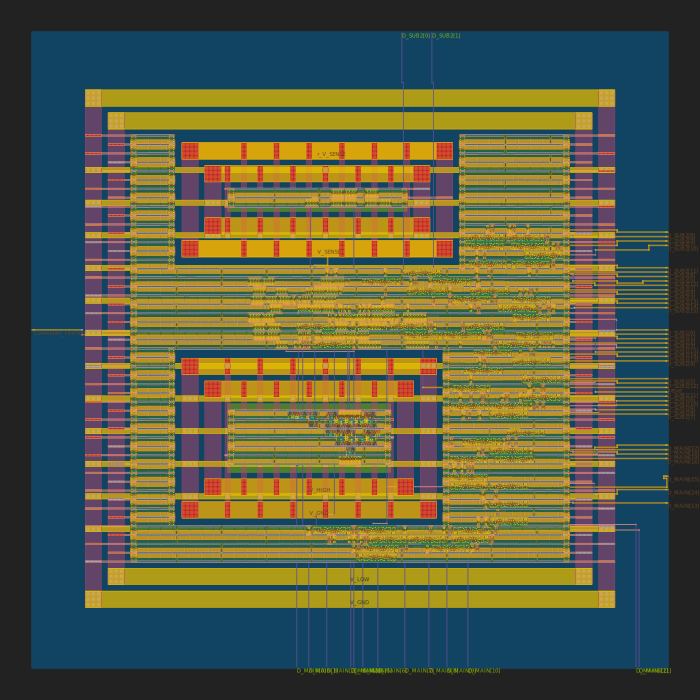

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg

# convert def to gds
%cd /content/RyanCaginalp_CDC
!klayout -zz -rd design_name="CDC" \
         -rd in_def="Routed.def" \
         -rd in_files="GDS/sky130_fd_sc_hd.gds GDS/transmission_gate.gds" \
         -rd config_file="JSON/fill.json" \
         -rd seal_file="" \
         -rd out_file="Routed.gds" \
         -rd tech_file="Klayout_Files/klayout.lyt" \
         -rd layer_map= \
         -r PYTHON/def2stream.py

routed = gdstk.read_gds("Routed.gds")
routed_top_cell = routed.top_level()
routed_top_cell[0].write_svg('Routed.svg')
fig = sg.fromfile('Routed.svg')
fig.set_size(('700','700'))
fig.save('Routed.svg')
IPython.display.SVG('Routed.svg')

The below segment consilidates everything into a complete GDS file called "Final.gds". It will be located in the "/content/RyanCaginalp_CDC" directory if one wishes to download it. The other GDS files used to generate the above graphics are also in this directory, and are named after the process that was just completed (ex: the GDS file after floorplanning is called "Floorplanned.gds".)

In [ ]:
%cd /content/RyanCaginalp_CDC
!bash Finishing.sh

/content/RyanCaginalp_CDC
[INFO] Reporting cells prior to loading DEF ...
[INFO] Reading DEF ...
[INFO] Clearing cells...
[INFO] Merging GDS/OAS files...
	GDS/sky130_fd_sc_hd.gds
	GDS/transmission_gate.gds
[INFO] Copying toplevel cell 'CDC'
INFO: Reading config file: JSON/fill.json
[INFO] Checking for missing cell from GDS/OAS...
[INFO] All LEF cells have matching GDS/OAS cells
[INFO] Checking for orphan cell in the final layout...
[INFO] No orphan cells
[INFO] Writing out GDS/OAS 'Final.gds'


#DRC
DRC, which stands for design rule check, runs a series of checks to ensure that the design is manufacturable for the specified PDK. In this case, the PDK is SKY130, and the tool used to conduct DRC is Magic.

In [ ]:
%cd /content/RyanCaginalp_CDC
!bash DRC.sh

/content/RyanCaginalp_CDC

Magic 8.3 revision 450 - Compiled on Wed Nov 22 23:18:09 UTC 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Loading "TCL/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: LIB
Reading "VIA_M2M3_PR".
Saving contents of cell VIA_M2M3_PR
Reading "VIA_M1M2_PR".
Saving contents of cell VIA_M1M2_PR
Reading "VIA_L1M1_PR_MR".
Saving contents of cell VIA_L1M1_PR_MR
Reading "VIA_via5_6_5000_5000_3_3_1600_1600".
Saving contents of cell VIA_via5_6_5000_5000_3_3_1600_1600
Reading "VIA_via2_3_540_490_1_1_32

#LVS
LVS, which stands for layout vs schematic, ensures that the output GDS file has the same functionality as the input schematic. It does this by extracting a SPICE file from the output GDS layout, and compares it against a provided schematic SPICE file to ensure that they are topologically identical. The SPICE file is extracted from the GDS layout using Magic, while the SPICE schematic is created from the YoSys output during synthesis. Finally, the topological comparison is done using Netgen.

In [ ]:
%cd /content/RyanCaginalp_CDC
!bash LVS.sh

/content/RyanCaginalp_CDC

Magic 8.3 revision 450 - Compiled on Wed Nov 22 23:18:09 UTC 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Loading "LVS/Magic_Extraction.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: LIB
Reading "VIA_M2M3_PR".
Reading "VIA_M1M2_PR".
Reading "VIA_L1M1_PR_MR".
Reading "VIA_via5_6_5000_5000_3_3_1600_1600".
Reading "VIA_via2_3_540_490_1_1_320_320".
Reading "VIA_via3_4_540_490_1_1_400_400".
Reading "VIA_via4_5_540_490_1_1_400_400".
Reading "VIA_via2_3_740_490_1_2_320_320".
Reading "VIA_via3_4_740_490_1_2_40

#Simulation
Finally, a SPICE file with parasitic capacitances is extracted form the output GDS layout using Magic, and is tested using NgSpice under simulation. Two simulations are done using two input capacitances, and the results are used to calculate design properties. Please bear in mind these properties will differ slightly from the predicted values due to the simulated results being conducted under different versions of the tools, as well as possible interpolation inaccuracies. Also, be advised that simulations can take over half an hour.

In [ ]:
%cd /content/RyanCaginalp_CDC
from Interpolation import SimInterpolation
from Data_Reader import data_reader

#First extract the SPICE file from the complete gds file
print("Extracting SPICE File...")
!magic -rcfile /content/conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc -noconsole -dnull NgSpice/Magic_Extraction.tcl
!python3 NgSpice/SPICE_Port_Fixer.py
print("Extraction Complete.")

#Get the simulation parameters
cap1, time1, cap2, time2 = SimInterpolation("Time_Data.csv", selected_size, selected_length)

#Use them to get execution and simulation time (time we measure and time we simulate, respectively)
execution_time1 = int((time1 - 60) * 0.8 + 60)
simulation_time1 = int((time1 - 60) * 1.5 + 60)

execution_time2 = int((time2 - 60) * 0.8 + 60)
simulation_time2 = int((time2 - 60) * 1.5 + 60)

#Now run the first simulation
print("Running first simulation...")
!python3 NgSpice/Simulation_Configuration.py $simulation_time1 $execution_time1 60 $cap1
!ngspice -b NgSpice/CDC_PEX_Test.cir -o NgSpice/Sim1.log
print("First simulation complete.")

#Read the simulation results
low_power, high_power, stop_time, total_energy, ds1, ds2, dm = data_reader("NgSpice/Sim1.log", 6 * pow(10, -8), 40 * pow(10, -12))

measurement_time1 = stop_time
energy1 = total_energy
output_result1 = dm * 2 - ds1 - ds2

#Now run the second simulation
print("Running second simulation...")
!python3 NgSpice/Simulation_Configuration.py $simulation_time2 $execution_time2 60 $cap2
!ngspice -b NgSpice/CDC_PEX_Test.cir -o NgSpice/Sim2.log
print("Second simulation complete.")

#Read the simulation results
low_power, high_power, stop_time, total_energy, ds1, ds2, dm = data_reader("NgSpice/Sim2.log", 6 * pow(10, -8), 40 * pow(10, -12))

measurement_time2 = stop_time
energy2 = total_energy
output_result2 = dm * 2 - ds1 - ds2

Energy_per_Capacitance = (energy2 - energy1)/((cap2 - cap1) * pow(10, -12))
Time_per_Capacitance = (measurement_time2 - measurement_time1)/((cap2 - cap1) * pow(10, -9))
Step_Size = ((cap2 - cap1))/(output_result2 - output_result1)

print()
if not Targeted_or_Fom: print("Simulated FoM: " + str(FoM(Energy_per_Capacitance, Time_per_Capacitance, Step_Size)))
print("Simulated Energy per Input Capacitance (J/F): " + str(Energy_per_Capacitance))
print("Simulated Measurement Time per Input Capacitance (S/mF): " + str(Time_per_Capacitance))
print("Simulated Output Resolution (pF): " + str(Step_Size))

/content/RyanCaginalp_CDC
Extracting SPICE File...

Magic 8.3 revision 450 - Compiled on Wed Nov 22 23:18:09 UTC 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Loading "NgSpice/Magic_Extraction.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: LIB
Reading "VIA_M2M3_PR".
Reading "VIA_M1M2_PR".
Reading "VIA_L1M1_PR_MR".
Reading "VIA_via5_6_5000_5000_3_3_1600_1600".
Reading "VIA_via2_3_540_490_1_1_320_320".
Reading "VIA_via3_4_540_490_1_1_400_400".
Reading "VIA_via4_5_540_490_1_1_400_400".
Reading "VIA_via2_3_740_490_1_2_320_320".
Readi